<a href="https://colab.research.google.com/github/CamiSilvae/PDI/blob/main/ClaseOrdinaria/PIA/PDI_PIA_Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Producto Integrador de Aprendizaje

---

EQUIPO 4

*   2109522 - Camila Andrea Silva Espinoza
*   2049215 - Norma Cecilia Cázares del Ángel
*   2023982 - Zoe Daniela Vazquez Jurado
*   2002572 - Fernanda Montserrat Luque Hernandez


## Caso de estudio 1

**SEGMENTACIÓN Y DETECCIÓN DE TUMOR CEREBRAL EN IMAGEN MRI**

---

**1. Carga de imagen**

En esta primera parte, se carga la médica que se utilizará en todo el proyecto. Para ello, se permite al usuario seleccionar un archivo desde su computadora mediante un cuadro de carga interactivo. La imagen se convierte a escala de grises para facilitar su procesamiento y asegurar compatibilidad con técnicas de realce, filtrado y segmentación. Finalmente, se muestra la imagen original para confirmar que la carga fue exitosa.

Selecciona la imagen médica a analizar:


Saving TumorCerebral.png to TumorCerebral.png


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

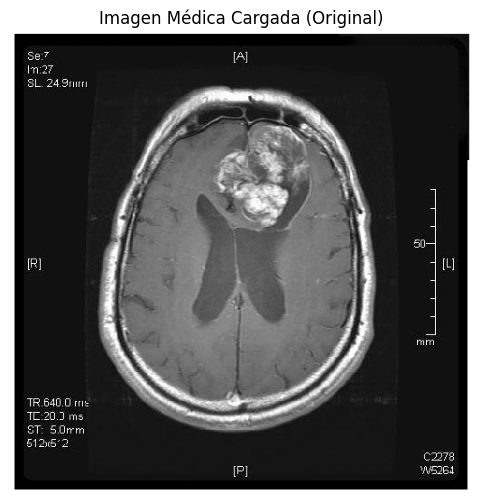

In [4]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("Selecciona la imagen médica a analizar:")
uploaded = files.upload()

image_name = list(uploaded.keys())[0]

img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(6,6))
plt.title("Imagen Médica Cargada (Original)")
plt.imshow(img, cmap='gray')
plt.axis('off')


**2. Mejora de visibilidad y contraste**

Después, realizamos la mejora del contraste de la imagen médica mediante la técnica de ecualización de histograma, la cual redistribuye los niveles de intensidad para resaltar estructuras y detalles que podrían pasar desapercibidos. Esto es especialmente útil en imágenes con bajo contraste, como radiografías o resonancias.
Además, se muestran los histogramas antes y después del proceso, lo que permite visualizar cómo cambia la distribución de intensidades y comprobar que el realce del contraste ha sido efectivo.

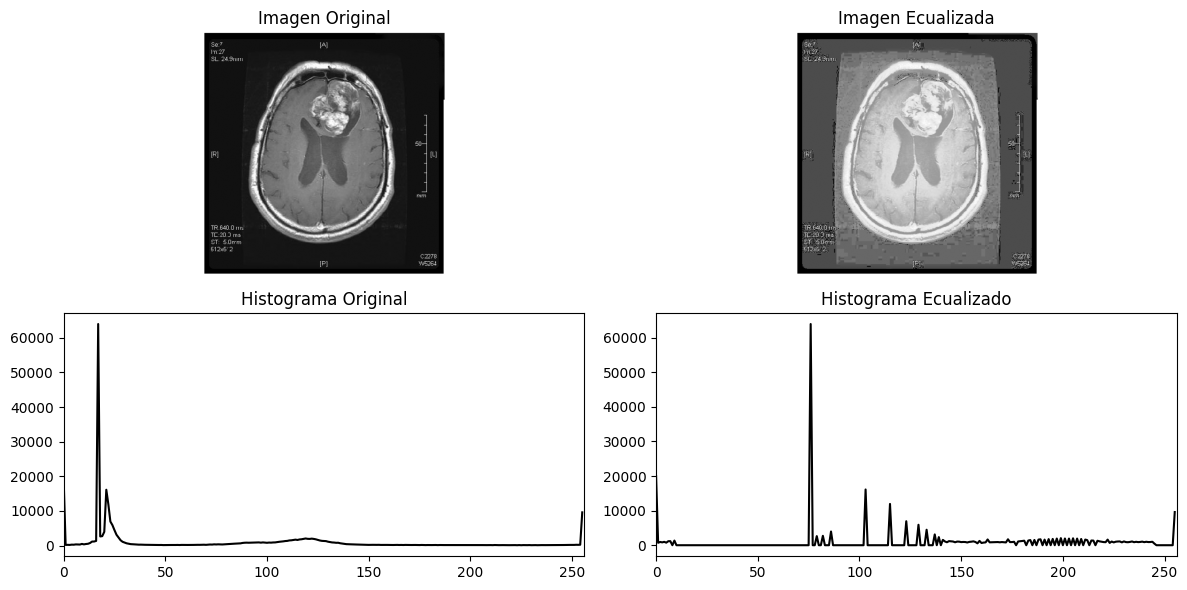

In [5]:
hist_original = cv2.calcHist([img], [0], None, [256], [0, 256])

img_eq = cv2.equalizeHist(img)

hist_eq = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.title("Imagen Original")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2,2,2)
plt.title("Imagen Ecualizada")
plt.imshow(img_eq, cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.title("Histograma Original")
plt.plot(hist_original, color='black')
plt.xlim([0,256])

plt.subplot(2,2,4)
plt.title("Histograma Ecualizado")
plt.plot(hist_eq, color='black')
plt.xlim([0,256])

plt.tight_layout()
plt.show()


**3. Filtrado y preprocesamiento**

*Eliminación de ruido mediante el uso del filtro Gaussiano/Mediana*

La etapa de filtrado tiene como objetivo reducir el ruido presente en la imagen médica sin perder estructuras importantes. El ruido puede deberse a condiciones del equipo, movimiento del paciente o interferencias del entorno. Para este proceso existen dos filtros comunes:

Filtro Gaussiano: aplica una operación de suavizado basada en una distribución normal. Este filtro es ideal para reducir ruido tipo gaussiano y actúa suavizando progresivamente las variaciones abruptas. Produce imágenes más suaves sin distorsionar demasiado los contornos.

Filtro de Mediana: sustituye cada píxel por la mediana de sus vecinos. Es especialmente útil para eliminar ruido impulsivo o “sal y pimienta”, característico en muchas imágenes médicas. A diferencia del Gaussiano, conserva mejor los bordes porque no promedia valores extremos.

En procesamiento de imágenes médicas, estos filtros permiten mejorar la calidad visual, facilitar la segmentación y preparar la imagen para operaciones posteriores como detección de bordes y umbralización.

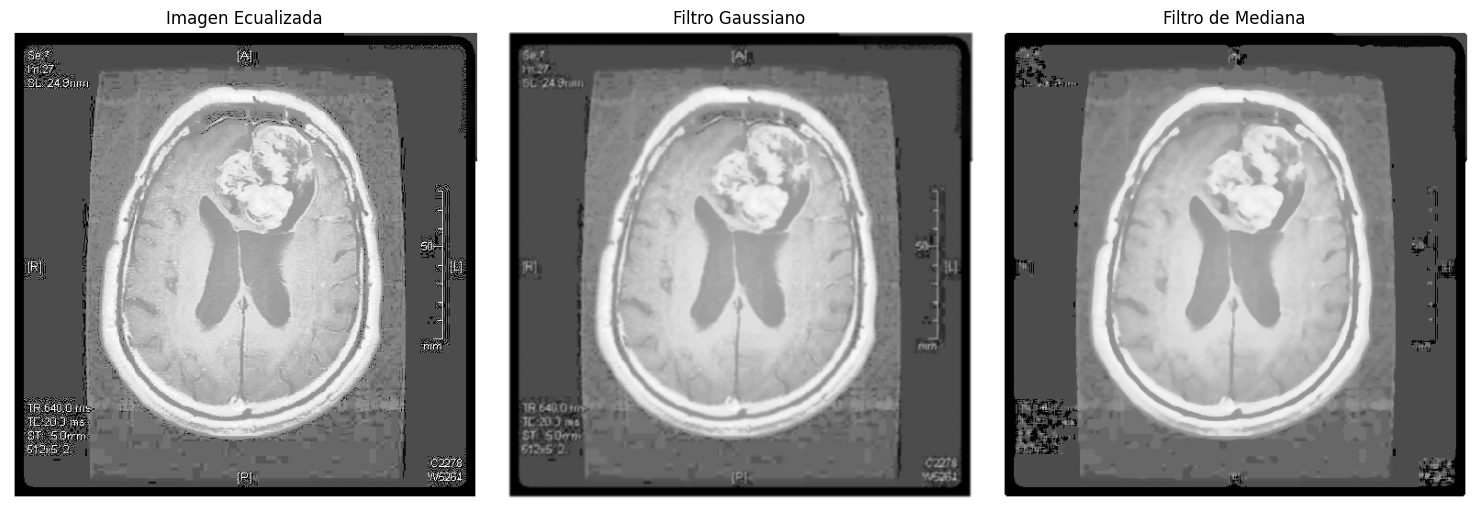

In [6]:
img_gauss = cv2.GaussianBlur(img_eq, (5,5), 1)
img_med = cv2.medianBlur(img_eq, 5)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Imagen Ecualizada")
plt.imshow(img_eq, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Filtro Gaussiano")
plt.imshow(img_gauss, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Filtro de Mediana")
plt.imshow(img_med, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

*Resaltado de bordes usando el filtro Sobel o Lapciano*

En esta etapa se aplican técnicas de detección de bordes con el objetivo de resaltar las transiciones bruscas de intensidad dentro de la imagen médica. Estas transiciones suelen corresponder a límites anatómicos, contornos de estructuras internas o posibles regiones anómalas como un tumor.

El filtro Sobel calcula derivadas en direcciones horizontal y vertical, permitiendo detectar bordes con orientación específica y generar un mapa de magnitud de bordes. Esto ayuda a resaltar cambios direccionales que pueden delimitar tejidos o estructuras relevantes.

Por otro lado, el filtro Laplaciano obtiene la segunda derivada de la imagen, por lo que responde intensamente ante cambios abruptos de intensidad sin importar la dirección del borde. Es útil para destacar contornos más generales o áreas donde la textura cambia de manera notable.

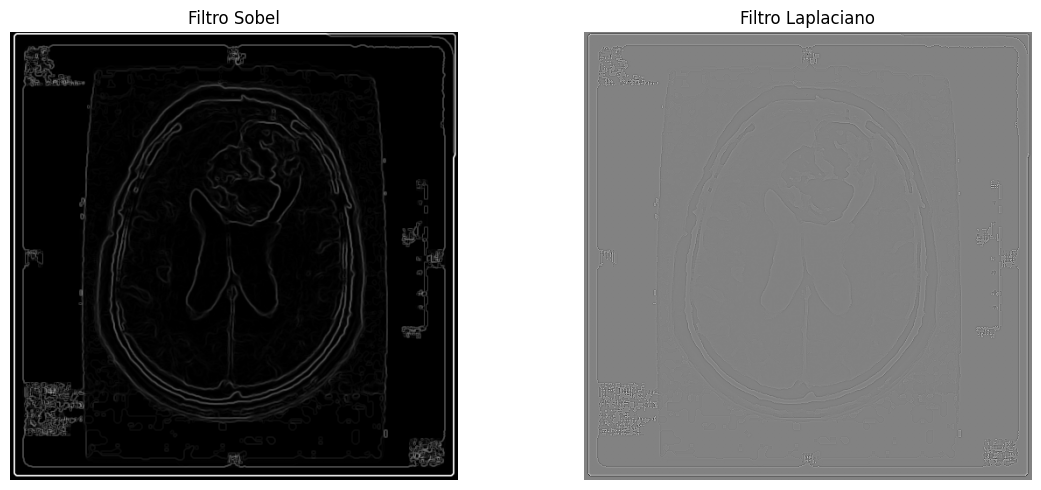

In [7]:
sobel_x = cv2.Sobel(img_med, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(img_med, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)

laplace = cv2.Laplacian(img_med, cv2.CV_64F)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Filtro Sobel")
plt.imshow(sobel, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Filtro Laplaciano")
plt.imshow(laplace, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

**4. Segmentación de regiones sospechosas**

*Segmentación por Umbral adaptativo u Otsu para detectar zonas hiperdensas*

En esta etapa se realiza la segmentación inicial de la imagen con el propósito de aislar regiones que presenten intensidades anormalmente altas, conocidas como zonas hiperdensas. Este tipo de áreas suele asociarse con alteraciones anatómicas, entre ellas tumores, acumulaciones anómalas o regiones de interés clínico.

El método aplicado es el algoritmo de Otsu, una técnica de umbralización automática que determina de manera óptima el valor de separación entre fondo y objeto sin intervención del usuario. Otsu analiza el histograma de intensidades y selecciona el umbral que maximiza la diferencia entre clases, es decir, que distingue de forma más clara las regiones brillantes del resto del tejido.

Este proceso convierte la imagen filtrada en una máscara binaria que resalta únicamente los píxeles que superan el umbral óptimo. Gracias a ello, las zonas potencialmente anómalas pueden visualizarse con mayor claridad, facilitando el siguiente paso de refinamiento morfológico y análisis de componentes.

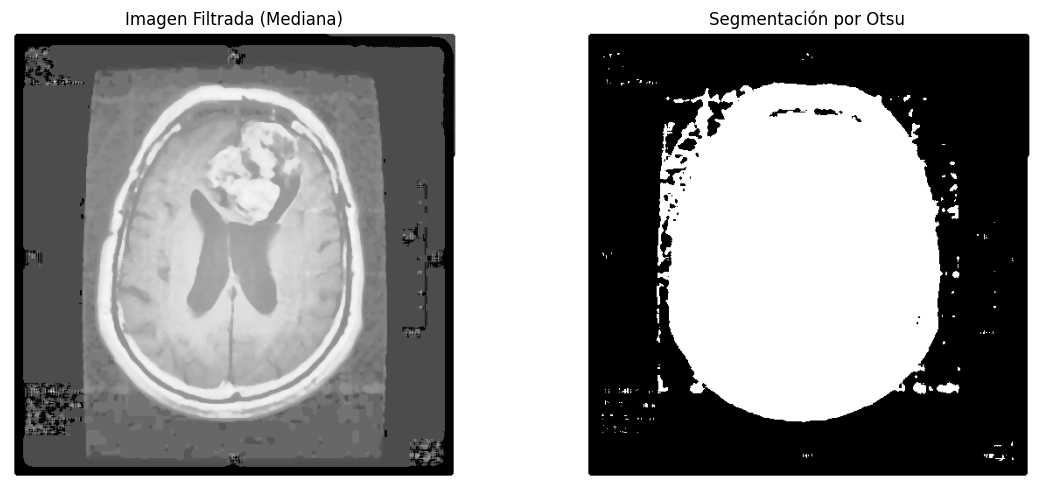

In [8]:
_, otsu = cv2.threshold(img_med, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Imagen Filtrada (Mediana)")
plt.imshow(img_med, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Segmentación por Otsu")
plt.imshow(otsu, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

*Segmentación morfológica (Erosión, Dilatación) para refinar bordes y máscara binario de regiones sospechosas*

Después de obtener la segmentación inicial mediante el método de Otsu, es necesario refinar la máscara resultante, ya que puede contener ruido, bordes irregulares o pequeñas regiones desconectadas que no corresponden a un área sospechosa real. Para este propósito se aplican las operaciones morfológicas de erosión y dilatación, ampliamente utilizadas en el procesamiento de imágenes biomédicas.

La erosión elimina píxeles periféricos y reduce el grosor de las regiones segmentadas, lo que ayuda a eliminar puntos aislados, artefactos y pequeñas imperfecciones que puedan interferir con análisis posteriores. Posteriormente, la dilatación expande nuevamente las regiones restantes, recuperando la forma general de la estructura pero ahora con bordes más limpios, homogéneos y definidos.

El resultado de esta secuencia (erosión seguida de dilatación) es una máscara morfológicamente refinada que representa de manera más precisa las regiones sospechosas detectadas. Este paso es fundamental para asegurar que los contornos y las áreas analizadas posteriormente correspondan realmente a estructuras relevantes en la imagen médica.

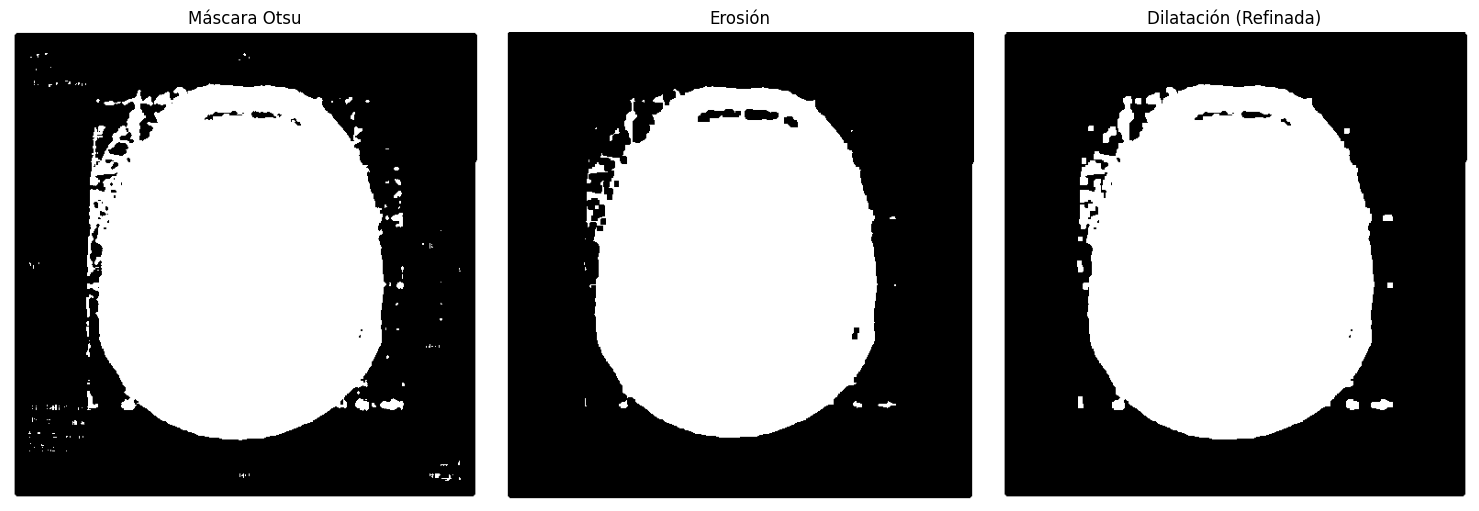

In [9]:
kernel = np.ones((5,5), np.uint8)

erosion = cv2.erode(otsu, kernel, iterations=1)
dilatacion = cv2.dilate(erosion, kernel, iterations=1)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Máscara Otsu")
plt.imshow(otsu, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Erosión")
plt.imshow(erosion, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Dilatación (Refinada)")
plt.imshow(dilatacion, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

**5. Segmentación avanzada**

*Basado en clústeres (K-means) para separar tejidos por intensidad*

En este apartado se utiliza una técnica de segmentación, el algoritmo K-means clustering. Su propósito es separar los diferentes tejidos presentes en la imagen médica según su nivel de intensidad, agrupando píxeles similares en clústeres o clases. Esta técnica es especialmente útil en imágenes MRI, donde diferentes tipos de tejido (materia gris, materia blanca, líquido cefalorraquídeo, o regiones anómalas) presentan intensidades características que pueden diferenciarse de forma automática.

El algoritmo convierte la imagen en un arreglo unidimensional de píxeles y agrupa dichos valores en k clústeres definidos por intensidades promedio. En este caso, se trabaja con k = 3, lo que permite separar la imagen en tres grupos: uno para intensidades bajas, uno para medias y otro para altas. Una vez finalizado el proceso, cada píxel se etiqueta según el clúster al que pertenece y se reconstruye una imagen segmentada donde cada tejido aparece representado con valores homogéneos.

Este método facilita la identificación de regiones que puedan corresponder a estructuras relevantes o posibles anomalías, ya que los tejidos se muestran claramente diferenciados. Asimismo, constituye una segmentación más robusta que la umbralización simple, pues no depende de un único nivel de intensidad sino de la relación global entre los valores de toda la imagen.

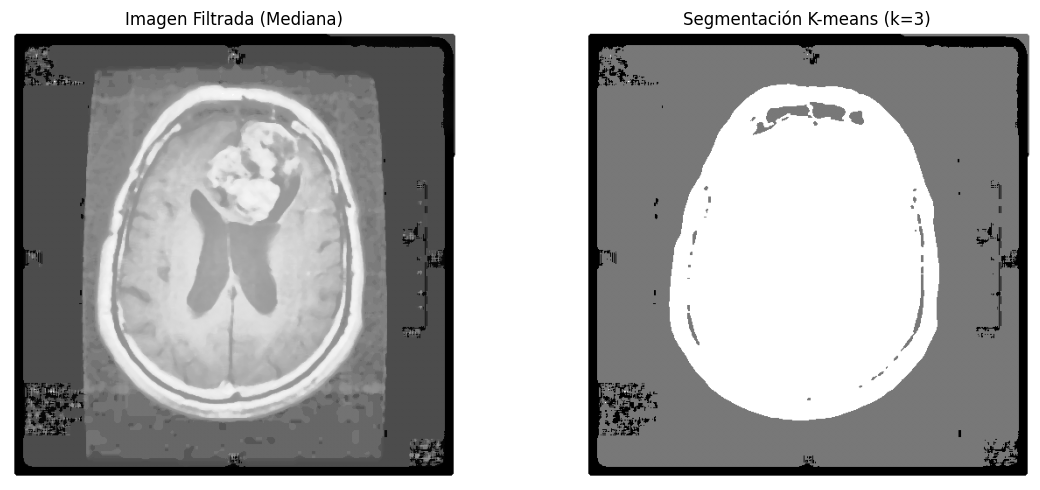

In [10]:
pixel_vals = img_med.reshape((-1, 1))
pixel_vals = np.float32(pixel_vals)

k = 3
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

_, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers = np.uint8(centers)
segmented = centers[labels.flatten()]
segmented_img = segmented.reshape(img_med.shape)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Imagen Filtrada (Mediana)")
plt.imshow(img_med, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title(f"Segmentación K-means (k={k})")
plt.imshow(segmented_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

**6. Análisis de componentes**

*Cálculo de área, forma, perímetro, compacidad centroide*

En esta etapa se realiza un análisis cuantitativo de las regiones segmentadas con el fin de obtener medidas geométricas que permitan describir su tamaño, forma y ubicación dentro de la imagen médica. Estos parámetros son fundamentales en el procesamiento de imágenes biomédicas, ya que ayudan a caracterizar y comparar posibles lesiones o anomalías detectadas.

Primero, se obtiene una máscara binaria a partir de la segmentación previa y se identifican los contornos presentes en la imagen. De todos ellos, se selecciona el contorno de mayor tamaño, asumiendo que corresponde a la región más relevante para el análisis. A partir de este contorno se calcula:


*   Área: número de píxeles contenidos dentro del contorno, útil para estimar el tamaño de la estructura.
*   Perímetro: longitud total del borde del contorno, que aporta información sobre la complejidad de la forma.
*   Compacidad: medida que relaciona área y perímetro; valores altos indican formas irregulares, mientras que valores cercanos a 1 sugieren estructuras más redondeadas y compactas.
*   Centroide: punto geométrico central de la región, obtenido mediante los momentos espaciales, que permite localizar con precisión la posición de la estructura dentro de la imagen.

Finalmente, se visualiza la región analizada marcando el contorno detectado y el centroide sobre la imagen filtrada. Esta representación facilita la interpretación clínica, pues muestra claramente qué estructura fue detectada y evaluada durante el análisis.

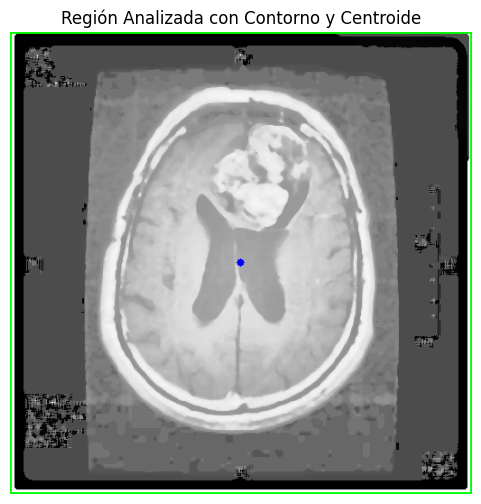

In [11]:
_, mask_bin = cv2.threshold(segmented_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

mask_bin = (mask_bin > 0).astype(np.uint8)

contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnt = max(contours, key=cv2.contourArea)

area = cv2.contourArea(cnt)
perimeter = cv2.arcLength(cnt, True)

compactness = (perimeter**2) / (4 * np.pi * area)

M = cv2.moments(cnt)
cx = int(M["m10"] / M["m00"])
cy = int(M["m01"] / M["m00"])

img_features = cv2.cvtColor(img_med, cv2.COLOR_GRAY2BGR)
cv2.drawContours(img_features, [cnt], -1, (0, 255, 0), 2)
cv2.circle(img_features, (cx, cy), 4, (0, 0, 255), -1)

plt.figure(figsize=(6,6))
plt.title("Región Analizada con Contorno y Centroide")
plt.imshow(img_features)
plt.axis('off')

plt.show()


* *Clasificación simple por tamaño (umbral para "sospechoso")*

En esta etapa se utiliza la información geométrica obtenida previamente para realizar una clasificación inicial basada únicamente en el tamaño de la región analizada. Este tipo de aproximación es común en sistemas de apoyo al diagnóstico, donde se emplean criterios simples como primer filtro para identificar estructuras que podrían requerir un análisis más detallado.

Primero, se muestran los valores calculados durante el análisis de componentes, incluyendo área, perímetro, compacidad y coordenadas del centroide. Esto permite verificar numéricamente las características principales de la región segmentada y proporciona un contexto cuantitativo para la clasificación.

Posteriormente, se establece un umbral de área que sirve como criterio para distinguir entre regiones consideradas normales y aquellas cuyo tamaño podría resultar inusual. Si el área de la región supera este umbral, se clasifica como una posible lesión sospechosa, ya que un tamaño significativamente grande puede estar asociado a masas anormales, acumulaciones de tejido o estructuras patológicas. En caso contrario, la región se clasifica como dentro de un rango no sospechoso, indicando que su tamaño no sugiere anomalías relevantes.

In [12]:
print("----- RESULTADOS DEL ANÁLISIS -----")
print(f"Área estimada: {area:.2f} píxeles")
print(f"Perímetro: {perimeter:.2f}")
print(f"Compacidad: {compactness:.4f}")
print(f"Centroide: ({cx}, {cy})")

umbral_sospechoso = 3000

if area > umbral_sospechoso:
    print("\nClasificación: POSIBLE LESIÓN SOSPECHOSA (área grande)")
else:
    print("\nClasificación: TAMANO DENTRO DE RANGO NO SOSPECHOSO")


----- RESULTADOS DEL ANÁLISIS -----
Área estimada: 261121.00 píxeles
Perímetro: 2044.00
Compacidad: 1.2732
Centroide: (255, 255)

Clasificación: POSIBLE LESIÓN SOSPECHOSA (área grande)


**7. Transformada de Fourier**

*Visualización del espectro frecuencial*

En este paso transformamos la imagen al dominio de las frecuencias usando la Transformada de Fourier. Esto nos permite ver qué partes de la imagen corresponden a información suave (bajas frecuencias) y cuáles representan detalles finos o ruido (altas frecuencias). El espectro nos ayuda a entender la estructura global de la imagen y a decidir qué tipo de filtrado es más útil para mejorarla.

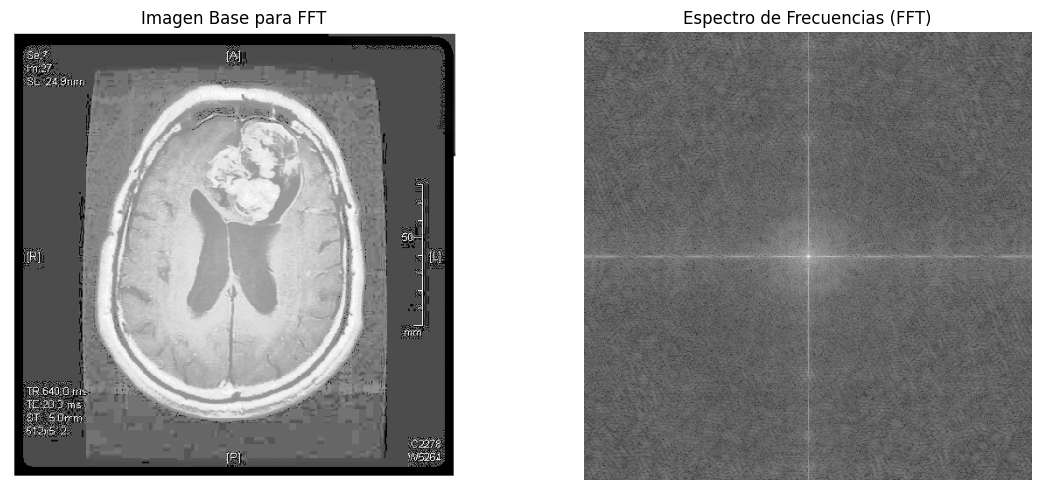

In [13]:

img_fft_base = img_eq

fft = np.fft.fft2(img_fft_base)
fft_shift = np.fft.fftshift(fft)

magnitude = np.log(np.abs(fft_shift) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Imagen Base para FFT")
plt.imshow(img_fft_base, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Espectro de Frecuencias (FFT)")
plt.imshow(magnitude, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


*Filtrado de frecuencias altas para eliminar ruido*

Básicamente deja pasar solo las frecuencias bajas del espectro y bloquea las altas. Las altas frecuencias suelen estar asociadas con ruido, así que al suprimirlas obtenemos una imagen más suave y limpia. Este paso es muy útil cuando se quiere reducir granulado o artefactos antes de procesar la imagen con otras técnicas.

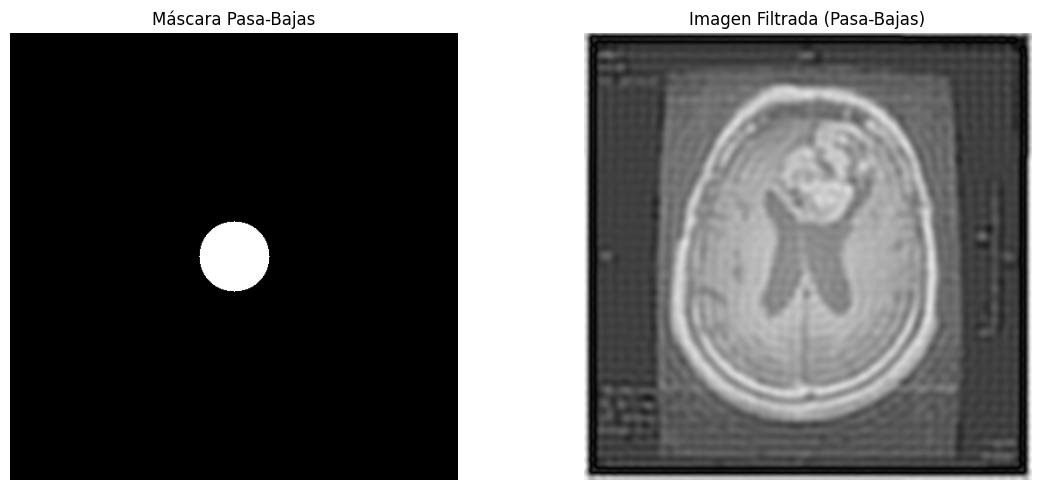

In [14]:
rows, cols = img_fft_base.shape
crow, ccol = rows//2, cols//2

mask_low = np.zeros((rows, cols), np.uint8)
r = 40  # radio del filtro (ajustable)
cv2.circle(mask_low, (ccol, crow), r, 1, -1)

low_pass = fft_shift * mask_low

low_pass_img = np.fft.ifft2(np.fft.ifftshift(low_pass))
low_pass_img = np.abs(low_pass_img)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Máscara Pasa-Bajas")
plt.imshow(mask_low, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Imagen Filtrada (Pasa-Bajas)")
plt.imshow(low_pass_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


*Mejorar estructuras mediante filtrado de pasa altas selectivo*

Hace lo opuesto: elimina las frecuencias bajas y deja pasar solo las altas. Esto sirve para resaltar bordes, contornos y estructuras finas dentro de la imagen. Al aplicar la transformada inversa, obtenemos una versión más “afilada” de la imagen, lo cual ayuda a identificar detalles o zonas anatómicas que podrían ser importantes en un análisis médico.

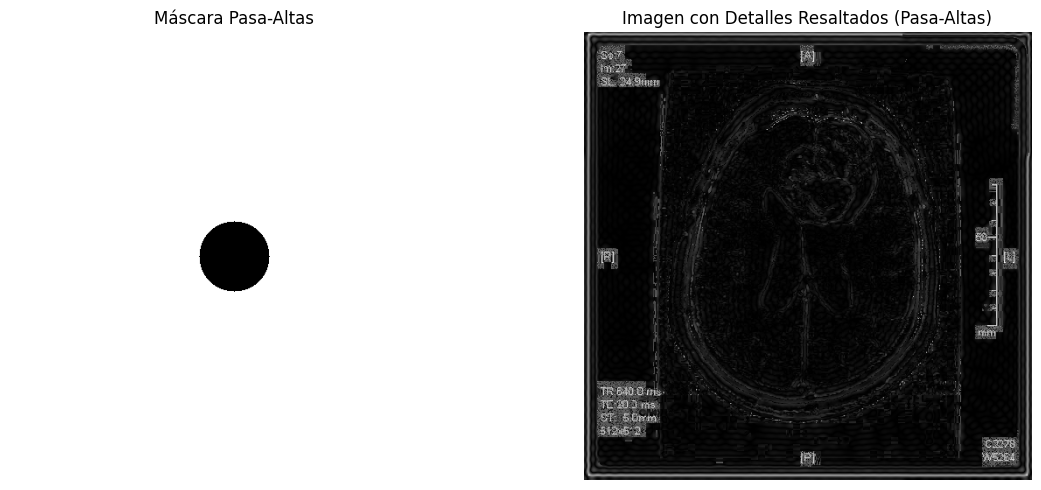

In [15]:
mask_high = 1 - mask_low

high_pass = fft_shift * mask_high

high_pass_img = np.fft.ifft2(np.fft.ifftshift(high_pass))
high_pass_img = np.abs(high_pass_img)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Máscara Pasa-Altas")
plt.imshow(mask_high, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Imagen con Detalles Resaltados (Pasa-Altas)")
plt.imshow(high_pass_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

## Resultados (Caso de Estudio 1)

**Compilación de resultados obtenidos**

En este último bloque se muestran los resultados más importantes generados por cada paso del procesamiento de la imagen MRI. El objetivo es ver, de manera clara, cómo fue cambiando la imagen y qué valores numéricos fueron obtenidos en cada etapa.

Aquí se imprimen datos como:

*  Tamaño y características básicas de la imagen original.

*  Cambios en el contraste después de ecualizar el histograma.

*  Resultados del filtrado de ruido.

*  Valores clave usados en la segmentación.

*  Información final sobre la detección del tumor y la máscara obtenida.

Este bloque sirve para comparar todas las fases del proceso y comprobar si cada paso está funcionando correctamente. Además, ayuda a entender si la segmentación del tumor fue buena y si los parámetros aplicados fueron adecuados.

En resumen, este bloque reúne toda la información útil para evaluar el desempeño del sistema y revisar que el procesamiento se realizó correctamente.

In [22]:
import numpy as np
import cv2

print("\n====================== REPORTE GLOBAL ======================\n")

print("\n--- PARTE 1: INFORMACIÓN DE LA IMAGEN ORIGINAL ---")

if 'img' not in globals() or img is None:
    print("Error: La imagen no está cargada. Ejecuta primero el bloque de carga.")
else:
    alto, ancho = img.shape
    print(f"Dimensiones: {alto} x {ancho} píxeles")
    print(f"Intensidad mínima: {np.min(img)}")
    print(f"Intensidad máxima: {np.max(img)}")
    print(f"Intensidad promedio: {np.mean(img):.2f}")
    print(f"Desviación estándar: {np.std(img):.2f}")

print("\n--- PARTE 2: MEJORA DE VISIBILIDAD Y CONTRASTE ---")

if 'img_eq' not in globals():
    print("La imagen ecualizada (img_eq) no existe. Ejecuta el bloque 2.")
else:
    print(f"Media original:   {np.mean(img):.2f}")
    print(f"Media ecualizada: {np.mean(img_eq):.2f}")
    print(f"STD original:     {np.std(img):.2f}")
    print(f"STD ecualizada:   {np.std(img_eq):.2f}")
    print("Se observó redistribución de intensidades en el histograma.")

print("\n--- PARTE 3: FILTRADO Y PREPROCESAMIENTO ---")

if 'img_med' not in globals():
    print("No se encontró img_med (filtro de mediana).")
else:
    print(f"Intensidad promedio tras filtro de mediana: {np.mean(img_med):.2f}")
    print(f"Ruido reducido (STD baja): {np.std(img_med):.2f}")

if 'sobel' in globals():
    print("Sobel calculado: bordes resaltados.")
if 'laplace' in globals():
    print("Laplaciano calculado: realce de cambios bruscos.")

print("\n--- PARTE 4: SEGMENTACIÓN POR OTSU ---")

if 'otsu' not in globals():
    print("No se ejecutó Otsu. Por favor corre esa celda.")
else:
    porcentaje_blanco = (np.sum(otsu > 0) / otsu.size) * 100
    print(f"Umbral Otsu aplicado.")
    print(f"Porcentaje de la imagen detectada como región brillante: {porcentaje_blanco:.2f}%")

print("\n--- PARTE 5: OPERACIONES MORFOLÓGICAS ---")

if 'dilatacion' not in globals():
    print("No se ejecutó la morfología (erosión/dilatación).")
else:
    print("Se aplicó erosión para eliminar ruido.")
    print("Se aplicó dilatación para restaurar la región principal.")

print("\n--- PARTE 6: SEGMENTACIÓN AVANZADA (K-MEANS) ---")

if 'segmented_img' not in globals():
    print("No se ejecutó k-means.")
else:
    intensidades = np.unique(segmented_img)
    print(f"K-means aplicado con clusters detectados: {len(intensidades)}")
    print(f"Centros de intensidad: {intensidades[:10]}")

print("\n--- PARTE 7: ANÁLISIS DE COMPONENTES ---")

if 'area' not in globals():
    print("No se encontraron contornos o no ejecutaste el bloque de análisis.")
else:
    print(f"Área de la lesión: {area:.2f} px")
    print(f"Perímetro: {perimeter:.2f}")
    print(f"Compacidad: {compactness:.4f}")
    print(f"Centroide: ({cx}, {cy})")

    if area > 3000:
        print("Clasificación: POSIBLE LESIÓN SOSPECHOSA")
    else:
        print("Clasificación: región pequeña, menos sospechosa.")


print("\n--- PARTE 8: ANÁLISIS EN FRECUENCIA (FFT) ---")

if 'magnitude' not in globals():
    print("No se ejecutó la transformada de Fourier.")
else:
    print("FFT calculada correctamente.")
    print("Espectro de frecuencias generado.")
    print("Se aplicó filtro Pasa-bajas.")
    print("Se aplicó filtro Pasa-altas.")


print("\n================ FIN DEL REPORTE ================\n")



====================== REPORTE GLOBAL ======================


--- PARTE 1: INFORMACIÓN DE LA IMAGEN ORIGINAL ---
Dimensiones: 512 x 512 píxeles
Intensidad mínima: 0
Intensidad máxima: 255
Intensidad promedio: 64.08
Desviación estándar: 68.03

--- PARTE 2: MEJORA DE VISIBILIDAD Y CONTRASTE ---
Media original:   64.08
Media ecualizada: 127.73
STD original:     68.03
STD ecualizada:   70.91
Se observó redistribución de intensidades en el histograma.

--- PARTE 3: FILTRADO Y PREPROCESAMIENTO ---
Intensidad promedio tras filtro de mediana: 127.50
Ruido reducido (STD baja): 69.13
Sobel calculado: bordes resaltados.
Laplaciano calculado: realce de cambios bruscos.

--- PARTE 4: SEGMENTACIÓN POR OTSU ---
Umbral Otsu aplicado.
Porcentaje de la imagen detectada como región brillante: 42.87%

--- PARTE 5: OPERACIONES MORFOLÓGICAS ---
Se aplicó erosión para eliminar ruido.
Se aplicó dilatación para restaurar la región principal.

--- PARTE 6: SEGMENTACIÓN AVANZADA (K-MEANS) ---
K-means aplicado 